In [1]:
#  constant AR process
import numpy as np
import matplotlib.pyplot as plt
# Length of time series
#
N=400
# Gaussian random numbers as an excitation signal
#
ex = np.random.randn(N)
# Second order AR Process
#
a = np.array([1.2, -0.4])
S = ex.copy();
for n in range(2, N):
    x = np.array([S[n-1], S[n-2]])
    S[n] = np.dot(x, a) + ex[n]
    

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6,4))
plt.tight_layout()

ax[0].plot(range(N), ex)
ax[0].grid(True)
ax[0].set_title("Random Excitation Signal")
ax[1].plot(range(N), S, color='m')
ax[1].grid(True)
ax[1].set_title("Autoregressive Process")

Text(0.5, 1, 'Autoregressive Process')

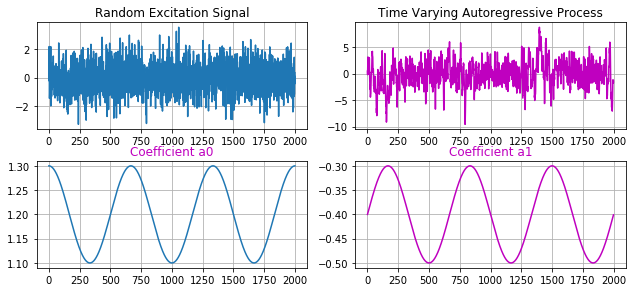

In [2]:
# time-varying AR process

import numpy as np
import matplotlib.pyplot as plt
# Length of time series
#
N=2000
# Gaussian random numbers as an excitation signal
#
ex = np.random.randn(N)
# Second order AR Process with coefficients slowly changing in time
#
a0 = np.array([1.2, -0.4])
A = np.zeros((N,2))
omega, alpha = N/2, 0.1
for n in range(N):
    A[n,0] = a0[0] + alpha * np.cos(6*np.pi*n/N)
    A[n,1] = a0[1] + alpha * np.sin(6*np.pi*n/N)
S = ex.copy();
for n in range(2, N):
    x = np.array([S[n-1], S[n-2]])
    S[n] = np.dot(x, A[n,:]) + ex[n]
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9,4))
plt.tight_layout()
ax[1,0].plot(range(N), A[:,0])
ax[1,0].grid(True)
ax[1,0].set_title("Coefficient a0", color='m')
ax[1,1].plot(range(N), A[:,1], color='m')
ax[1,1].grid(True)
ax[1,1].set_title("Coefficient a1", color='m')
ax[0,0].plot(range(N), ex)
ax[0,0].grid(True)
ax[0,0].set_title("Random Excitation Signal")
ax[0,1].plot(range(N), S, color='m')
ax[0,1].grid(True)
ax[0,1].set_title("Time Varying Autoregressive Process")
plt.show()

Text(0.5, 1.0, 'Initial Particles')

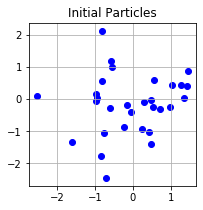

In [3]:
##Partile Filter Estimates of second order AR parameters
#100个粒子
Ns = 30
#Initial particles
parts = np.random.randn(Ns,2)
fig,ax = plt.subplots(figsize=(3,3))
ax.scatter(parts[:,0],parts[:,1],color='b')
ax.grid(True)
ax.set_title("Initial Particles")

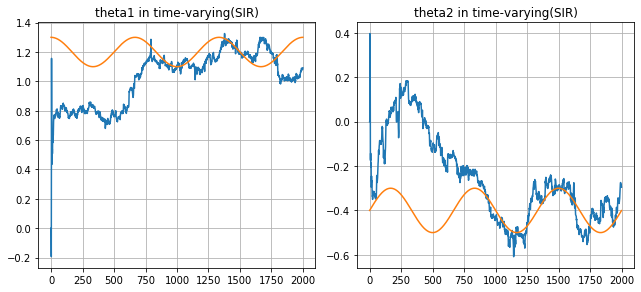

In [4]:
##尝试3
#高斯噪声似然
#Needs estimate true value and noise variance
def particle_likelihood(y0,yh,sig):
    lhood = (1/(2*np.pi*sig))*np.exp(-0.5*(y0-yh)**2)
    return lhood

def resample(parts,weights):
    reparts = np.zeros((Ns,2))
    newweights = np.ones((Ns,1))/Ns
    c = np.zeros(Ns)
    for i in range(1,Ns):
        c[i] = c[i-1]+weights[i]  # CDF
    u = np.zeros((Ns,1))
    u[0] = np.random.uniform(0,1/Ns)
    for j in range(1,Ns):
        u[j] = u[0]+(j-1)/Ns
        while (u[j] > c[i]) and (i !=( Ns-1)):
            i = i+1
        reparts[j] = parts[i]
        newweights[j] = 1/Ns
    return reparts,newweights

#Process noise covariance is beta*I
beta = 0.01

#Observation noise variance
sig = np.std(ex)

#Initial input vector and particle weights
x = np.zeros((2,1))
pweights = np.ones((Ns,1))/Ns

theta_track = np.zeros((N, 2))

#Go over the data
for n in range(2,N):
    x[0] = S[n-1]
    x[1] = S[n-2]
    
    #Sample particles from the prior
    #in the simplest case here, random perturbation
    for p in range(Ns):
        parts[p,:] = parts[p,:] + beta*np.random.randn(1,2)
        
    #Predictions and likelihoods
    sh = np.zeros((Ns,1))
    lhoods = sh.copy()
    for particle in range(Ns):
        th = parts[particle,:].T.copy()
        sh[particle] = x.T@th
        lhoods[particle] = particle_likelihood(S[n],sh[particle],sig)
    #multiply prior weights by likelihoods and normalize
    pweights = pweights * lhoods
    pweights = pweights / np.sum(pweights)
    
#     theta_track[n] = pweights.T @ parts
    pweights_resample = np.cumsum(pweights)
    pweights_resample[-1] = 1.  # avoid round-off error
    indexes = np.searchsorted(pweights_resample, np.random.rand(Ns))
    # resample according to indexes
    parts = parts[indexes]
    pweights.fill(1.0 / Ns)
    theta_track[n,0] = parts[:, 0].mean()
    theta_track[n,1] = parts[:, 1].mean()
#     parts,pweights = resample(parts,pweights)
#     for i in range(Ns):
#         theta_track[n] += parts[i] * pweights[i]
    #Observe how the weights change as you update
#     fig,ax = plt.subplots(figsize=(4,4))
#     ax.bar(np.arange(len(pweights)),pweights[:,0])


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,4))
plt.tight_layout()
ax[0].plot(theta_track[:,0])
ax[0].plot(range(N), A[:,0])
ax[0].grid(True)
ax[0].set_title("theta1 in time-varying(SIR)")
ax[1].plot(theta_track[:,1])
ax[1].grid(True)
ax[1].plot(range(N), A[:,1])
ax[1].set_title("theta2 in time-varying(SIR)")

plt.show()

Text(0.5, 1.0, 'Latest Particles')

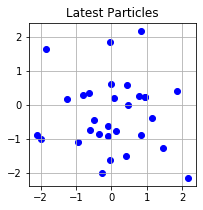

In [5]:
Ns = 30
#Initial particles
parts = np.random.randn(Ns,2)
fig,ax = plt.subplots(figsize=(3,3))
ax.scatter(parts[:,0],parts[:,1],color='b')
ax.grid(True)
ax.set_title("Latest Particles")